<img src="https://drive.google.com/uc?id=1YLNtm8gNsviTEnVXzfiby2VMKrc0XzLP" width="500"/>


---


# **Deep learning module introduction**

#### **Morning contents/agenda**

0. Start at the end

1. Description of the module's contents, materials and resources:
  - github repository
  - schedule and assessments
  - teaching team

2. Google Colab introduction

3. Deep learning?

4. Why `PyTorch`?

5. A simple feed-forward network (FFN) with `PyTorch`

#### **Learning outcomes**

1. Overview the module contents and how they will be delivered

2. Understand the assessment process for the module

3. First contact with `PyTorch` and FFNs

<br>


#### **Afternoon contents/agenda**

1. https://playground.tensorflow.org

2. Improving our simpleFFN

#### **Learning outcomes**

1. Understand the effect of different network configurations with tensorflow

2. Break the morning example and raise questions about how `PyTorch` works.


<br/>

---

<br/>


## 1. Tensorflow exercises

In [ ]:
%%html
<iframe src="https://playground.tensorflow.org" width="1200" height="700"></iframe>


Unless otherwise indicated, we work with the following hyper-parameters:
Learning rate =0.03, Batch Size=10, Noise=0, Training Data=70%.

Since there is a total of 500 data points, there are 350 (or 70%) training data and 150 test data.

We examine the behaviour of the networks until about 3500 epochs.

It is important to note that there will be differences between different runs obtained with the same hyperparameters, because the initial values of the neural network parameters (weights and bias terms) are sampled randomly.

The dataset itself may also change if you click the Regenerate Button at the bottom left of the screen.

We work on a classification problem on the Spiral dataset. The yellow dots have a value of -1 and the blue dots have a value of +1.





#### **Question 1:**
Use the sigmoid activation function and no hidden layer. What do you observe? How do you interpret it?

---

#### **Question 2:**
Now put just one hidden layer, a sigmoid activation function, and make the number of neurons in the hidden layer equal to 4. Then make it equal to the maximum offered by the application, that is 8. What is the number of trained parameters and what do you observe in each case?

---

#### **Question 3:**
Now do the same as in question 2, but using the ReLU activation function. What do you observe?

---

#### **Question 4:**
Now use two hidden layers each with four neurons and the ReLU activation function. How many trained parameters do you have? What do you observe?

---

#### **Question 5:**
Now try two hidden layers with 8 neurons each and a ReLU activation function. How many trained parameters do you have? What do you observe?

---

#### **Question 6:**
Now try three hidden layers with 8 neurons each. What happens if you compare sigmoid and ReLU?

---

#### **Question 7:**
Now keep the three layers with 8 neurons and change the batch size to 30, and then 1. What happens if you use ReLU?

---


#### **Question 8:**
Now that we have obtained a good model see what happens if you introduce all the 7 input variables

---


#### **Question 9:**
Now assume that the data are affected by noise. Just use the maximum noise value of 50. The application is not very clear about the mechanism by which the noise affects the initial data classes. This does not matter, just assume that, after introducing this noise value of 50, you are now dealing with new binary class values at each point. What do you observe?


<br>

---

<br>

## 2. `simpleFFN` exercise

Try to improve the performance of the network we implemented this morning. A few ideas and hints:

- modify the simpleFFN class to add more layers
- play with the sizes of the layers
- **don't touch** the train, validation, and evaluate functions
- anything else you see fit

I recommend that you copy-paste the code from this morning here, and then play editing it.

#### **Possible solution**:

Let's copy the code from this morning and add modifications.

### Code definition - Skip to Network training for now

In [3]:
import torch

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    device = 'cpu'

Cuda installed! Running on GPU!


In [4]:
!pip install pycm livelossplot
%pylab inline

# Let's start by importing some Python and `Pytorch` libraries and define a random seed to be able to replicate our results.
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. Useful when inputs do not change size -
    torch.backends.cudnn.enabled   = False

    return True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.3/606.3 kB 35.8 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


We create a class called `simpleFFN` and we test that it reads an input and gives us an output:

In [5]:
class simpleFFN(nn.Module):
  def __init__(self, num_hidden=(200, 50), bias=False, activation=nn.Sigmoid):
    super(simpleFFN, self).__init__()

    hidden_input = 784
    self.len_hidden = len(num_hidden)
    for idx, n in enumerate(num_hidden):
        setattr(self, 'hidden_%d' % idx, nn.Linear(hidden_input, n, bias=bias))
        hidden_input = n
    self.output = nn.Linear(hidden_input, 10, bias=bias)

    self.activation = activation()

  def forward(self, x):
    for idx in range(self.len_hidden):
        hidden = getattr(self, 'hidden_%d' % idx)
        z = hidden(x)
        x = self.activation(z)
    z = self.output(x)
    o = self.activation(z)
    return o

x = torch.randn((1, 1, 784))
model_test = simpleFFN()
y = model_test(x)
print(y)
print(model_test)



tensor([[[0.4992, 0.5674, 0.4413, 0.4076, 0.3702, 0.5090, 0.5431, 0.5199,
          0.4851, 0.4163]]], grad_fn=<SigmoidBackward0>)
simpleFFN(
  (hidden_0): Linear(in_features=784, out_features=200, bias=False)
  (hidden_1): Linear(in_features=200, out_features=50, bias=False)
  (output): Linear(in_features=50, out_features=10, bias=False)
  (activation): Sigmoid()
)


We download the MNIST dataset:

In [6]:
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 902kB/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



We split the data in training, validation, and test sets:

In [7]:
# split the data
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.train_data, mnist_train.train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


We standardise the data.

\[***NOTE***:
*As we will see in the coming weeks, even though this step is not strictly necessary, it does result in better performance because we are assuming that our data has some underlying Gaussian distribution (the errors rather). In general, it is good practice to standardise our data as it improves convergence speed and results in better generalisation.*\]

In [8]:
def apply_standardization(X): # define an standardisation function
  X /= 255.
  X -= 0.1307
  X /= 0.3081
  return X

# standardise the data
X_train, y_train = apply_standardization(mnist_train.train_data[indices[0]].float()), mnist_train.train_labels[indices[0]]
X_val, y_val = apply_standardization(mnist_train.train_data[indices[1]].float()), mnist_train.train_labels[indices[1]]
X_test, y_test =  apply_standardization(mnist_test.test_data.float()), mnist_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


We create TensorDatasets (more on this on the next two days):

In [9]:
# create the TensorDatasets containing mnist_train, mnist_validate, and mnist_test
mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

And we plot one of the elements of the training set (to check we loaded the data correctly)

tensor(0.0001) tensor(1.0003)


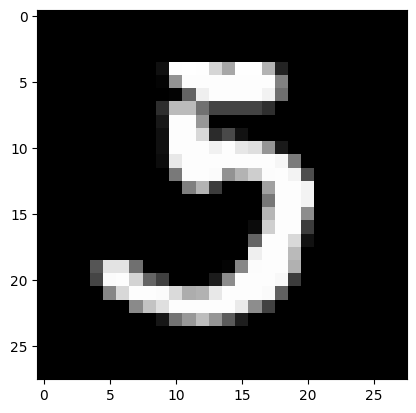

In [10]:
plt.imshow(X_train[11], cmap = 'gray')
print(X_train.mean(), X_train.std())

Now we are going to define functions to train and validate our network:

In [11]:
def train(model, optimizer, criterion, data_loader):
    model.train()                         # the model is in the training mode so the parameters(weights)to be optimised will be updated
    train_loss, train_accuracy = 0, 0     # initialise loss and accuracy to 0 for training
    for X, y in data_loader:              # iterate over the mini-batches defined in the data loader
        X, y = X.to(device), y.to(device) # send data to the device (GPU in our case)
        optimizer.zero_grad()             # resetting optimiser info
        a2 = model(X.view(-1, 28*28))     # forward pass
        loss = criterion(a2, y)           # compute loss
        loss.backward()                   # backpropagation to calculate the gradients
        train_loss += loss*X.size(0)      # # add it up for different mini-batches and undo loss normalisation
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # compute accuracy
        optimizer.step()                  # perform a step of gradient descent

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset


def validate(model, criterion, data_loader):      # does not need optimiser
    model.eval()                                  # model is set to evaluation mode so no dropout or any other funny stuff here
    validation_loss, validation_accuracy = 0., 0. # initialise loss and accuracy to 0 for training
    for X, y in data_loader:                      # iterate over the mini-batches defined in the data loader
        with torch.no_grad():                     # deactivates autograd engine
            X, y = X.to(device), y.to(device)     # send data to the device (GPU in our case)
            a2 = model(X.view(-1, 28*28))         # forward pass
            loss = criterion(a2, y)               # evaluate loss
            validation_loss += loss*X.size(0)     # add it up for different mini-batches and undo loss normalisation
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]  # get predictions
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # compute accuracy

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)  # here we can average over the whole dataset

In order to figure out how good it is, we need to implement an evaluate function:

In [12]:
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device) # data and labels to device
            a2 = model(X.view(-1, 28*28))     # forward pass and reshape tensor and get it ready to the fully connected layer
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # calculate prediction
            ys.append(y.cpu().numpy())        # save predictions
            y_preds.append(y_pred.cpu().numpy()) # save predictions

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0) ## concatenate the labels of each batch into a single list

Let's also create a function to instantiate our model and send it to the device:

In [13]:
def create_model(*args, **kwargs):
    model = simpleFFN(*args, **kwargs).to(device)                                              # instantiate model and send it to the GPU
    return model

And now we are ready to train our network:

In [14]:
def train_loop(model, seed, lr, momentum, batch_size, test_batch_size, n_epochs):
    set_seed(seed)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)   # instantiate the optimizer
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0) ## num_workers=0 means that the main process will retrieve the data.
    validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

    liveloss = PlotLosses()    # plots evolution of loss and accuracy
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy

        validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy

        liveloss.update(logs)
        liveloss.draw()
        print(validation_loss.item())

    return train_loader, validation_loader, test_loader

### Network training

Select the hyperparameters of our training (we will learn what each of these does during our second lecture):

In [23]:
seed = 42 ## ## keep at that if you want to get almost the exact same results (down to numerical precision I guess)
lr = 1e-2 ##
momentum = 0.9 ##
batch_size = 64 ##
test_batch_size = 1000 ##
n_epochs = 30 ##

Select the hyperparameters of our network:

In [30]:
num_hidden=(400,100,50) ##       # number of neurons in each hidden layer
bias= False##             # no bias
activation= nn.ReLU##       # sigmoid activation function

Let's create our network model:

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = create_model(num_hidden, bias=bias, activation=activation) ##
print(model)

simpleFFN(
  (hidden_0): Linear(in_features=784, out_features=400, bias=False)
  (hidden_1): Linear(in_features=400, out_features=100, bias=False)
  (hidden_2): Linear(in_features=100, out_features=50, bias=False)
  (output): Linear(in_features=50, out_features=10, bias=False)
  (activation): ReLU()
)


And now we are ready to train our network and display the evolution in real time:

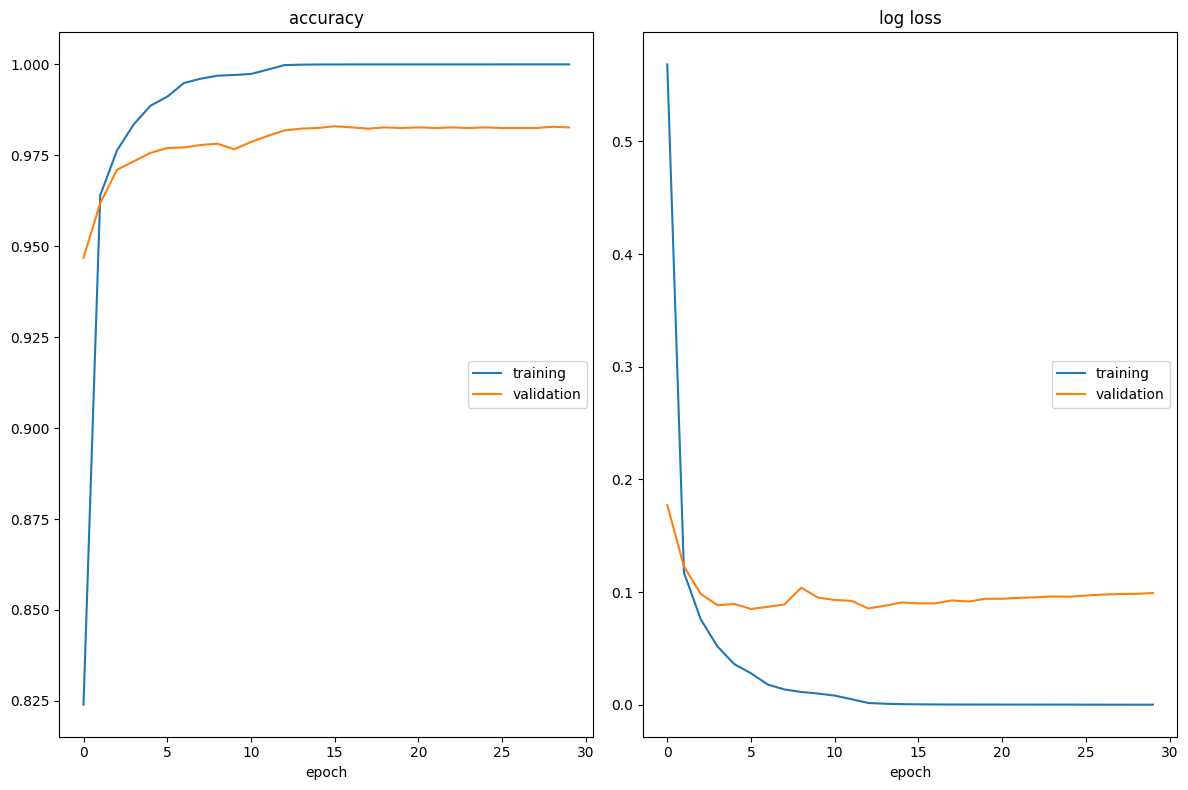

accuracy
	training         	 (min:    0.824, max:    1.000, cur:    1.000)
	validation       	 (min:    0.947, max:    0.983, cur:    0.983)
log loss
	training         	 (min:    0.000, max:    0.568, cur:    0.000)
	validation       	 (min:    0.085, max:    0.177, cur:    0.099)
0.09913685917854309


In [32]:
train_loader, validation_loader, test_loader = train_loop(model,seed,lr,momentum,batch_size, test_batch_size,n_epochs) ##

**How does the model perform with respect to before? Why?**

In [33]:
y_pred, y_gt = evaluate(model,test_loader) ##
print(y_pred, y_gt)

[7 2 1 ... 4 5 6] [7 2 1 ... 4 5 6]


Now we want to calculate the confusion matrix of the results we just generated, and plot it:

In [43]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(y_gt,y_pred) ## ## Create the confusion matrix from Data. ConfusionMatrix is a class derived from the pycm library
print(cm)

Predict    0          1          2          3          4          5          6          7          8          9          
Actual
0          972        0          1          0          0          1          3          0          1          2          

1          0          1128       1          0          0          0          2          1          3          0          

2          3          0          1016       5          1          0          1          4          2          0          

3          0          0          3          992        0          3          0          3          3          6          

4          1          1          3          0          963        0          3          1          0          10         

5          2          0          0          7          1          873        2          1          4          2          

6          3          2          1          0          5          3          944        0          0          0          

7         

/usr/local/lib/python3.10/dist-packages/pycm/cm.py:217: RuntimeWarning: Confusion matrix is high-dimensional and may not display properly. Consider using the `sparse` flag in printing functions, or save it as a CSV file for better visualization.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


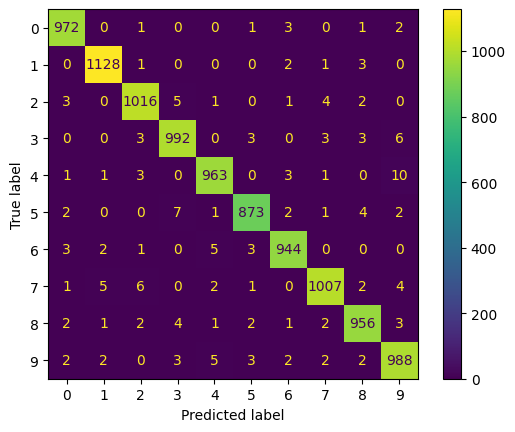

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

Matrix = confusion_matrix(y_gt,y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=Matrix)
disp.plot()

# fig, ax = plt.subplots(figsize=(6,6))
##
##